# Hacktiv8 Introduction to Python for Data Science - Project Assignment 2

Nama : Andrena Dhiffa Salsabila

Kode Peserta : PYTN-KS20-02

Kelas : PYTN-KS-20

## Project Overview

The dataset used in this project is NYC Property Sales Dataset from Kaggle. This dataset is a record of every building or building unit (apartment, etc.) sold in the New York City property market over a 12-month period.

This dataset contains the location, address, type, sale price, and sale date of building units sold. A reference on the trickier fields:

- BOROUGH: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).
- BLOCK; LOT: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a BBL.
- BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE: The type of building at various points in time.

Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

- Many sales occur with a nonsensically small dollar amount: $0 most commonly. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement.
- This dataset uses the financial definition of a building/building unit, for tax purposes. In case a single entity owns the building in question, a sale covers the value of the entire building. In case a building is owned piecemeal by its residents (a condominium), a sale refers to a single apartment (or group of apartments) owned by some individual.

## Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import scipy.stats
from scipy.stats import gaussian_kde
from scipy.stats import shapiro,jarque_bera
from statistics import NormalDist
from statsmodels.stats.diagnostic import lilliefors
from scipy.stats import shapiro

## Data

Read the CSV file as data_nyc

In [3]:
data_nyc = pd.read_csv('nyc-rolling-sales.csv')
data_nyc.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


## Data Cleaning

Create a copy of the original data by defining it as 'df', so the original data is not corrupt

In [4]:
df = data_nyc.copy()

Delete irrelevant coloumns

In [5]:
df = df.drop(["Unnamed: 0"],axis=1)

In [6]:
df.columns = df.columns.str.replace(" ","_")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         84548 non-null  int64 
 1   NEIGHBORHOOD                    84548 non-null  object
 2   BUILDING_CLASS_CATEGORY         84548 non-null  object
 3   TAX_CLASS_AT_PRESENT            84548 non-null  object
 4   BLOCK                           84548 non-null  int64 
 5   LOT                             84548 non-null  int64 
 6   EASE-MENT                       84548 non-null  object
 7   BUILDING_CLASS_AT_PRESENT       84548 non-null  object
 8   ADDRESS                         84548 non-null  object
 9   APARTMENT_NUMBER                84548 non-null  object
 10  ZIP_CODE                        84548 non-null  int64 
 11  RESIDENTIAL_UNITS               84548 non-null  int64 
 12  COMMERCIAL_UNITS                84548 non-null

Convert them to numeric variables

In [8]:
numerical_col = ["RESIDENTIAL_UNITS","COMMERCIAL_UNITS","TOTAL_UNITS", "LAND_SQUARE_FEET" , "GROSS_SQUARE_FEET","SALE_PRICE"]

for i in numerical_col: 
    df[i] = pd.to_numeric(df[i], errors='coerce')

Convert them to categorical variables

In [9]:
categorical_var = [var for var in df.columns if df[var].dtype=='O']
categorical_var

['NEIGHBORHOOD',
 'BUILDING_CLASS_CATEGORY',
 'TAX_CLASS_AT_PRESENT',
 'EASE-MENT',
 'BUILDING_CLASS_AT_PRESENT',
 'ADDRESS',
 'APARTMENT_NUMBER',
 'BUILDING_CLASS_AT_TIME_OF_SALE',
 'SALE_DATE']

Change _SALE_DATE_ coloumn to datetime

In [10]:
df["SALE_DATE"] = pd.to_datetime(df["SALE_DATE"])


Rename borough:

- 1 = Manhattan
- 2 = Bronx
- 3 = Brooklyn
- 4 = Queens
- 5 = Staten Island

In [11]:
df['BOROUGH'] = df.BOROUGH.replace({1: "Manhattan", 2: "Bronx", 3: "Brooklyn", 4: "Queens", 5: "Staten Islands"})
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,...,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,...,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19
1,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,...,28,3,31,4616.0,18690.0,1900,2,C7,NaN,2016-12-14
2,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,...,16,1,17,2212.0,7803.0,1900,2,C7,NaN,2016-12-09
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,...,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,...,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   BOROUGH                         84548 non-null  object        
 1   NEIGHBORHOOD                    84548 non-null  object        
 2   BUILDING_CLASS_CATEGORY         84548 non-null  object        
 3   TAX_CLASS_AT_PRESENT            84548 non-null  object        
 4   BLOCK                           84548 non-null  int64         
 5   LOT                             84548 non-null  int64         
 6   EASE-MENT                       84548 non-null  object        
 7   BUILDING_CLASS_AT_PRESENT       84548 non-null  object        
 8   ADDRESS                         84548 non-null  object        
 9   APARTMENT_NUMBER                84548 non-null  object        
 10  ZIP_CODE                        84548 non-null  int64         
 11  RE

Replace empty spaces with "NaN," then check will be conducted to determine whether the dataset contains data with missing values, empty entries, or duplicates

In [13]:
df.replace(' ',np.nan, inplace=True)
df.isna().sum() /len(df) *100

BOROUGH                             0.000000
NEIGHBORHOOD                        0.000000
BUILDING_CLASS_CATEGORY             0.000000
TAX_CLASS_AT_PRESENT                0.872877
BLOCK                               0.000000
LOT                                 0.000000
EASE-MENT                         100.000000
BUILDING_CLASS_AT_PRESENT           0.872877
ADDRESS                             0.000000
APARTMENT_NUMBER                   77.466055
ZIP_CODE                            0.000000
RESIDENTIAL_UNITS                   0.000000
COMMERCIAL_UNITS                    0.000000
TOTAL_UNITS                         0.000000
LAND_SQUARE_FEET                   31.049818
GROSS_SQUARE_FEET                  32.658372
YEAR_BUILT                          0.000000
TAX_CLASS_AT_TIME_OF_SALE           0.000000
BUILDING_CLASS_AT_TIME_OF_SALE      0.000000
SALE_PRICE                         17.222170
SALE_DATE                           0.000000
dtype: float64

Check the missing values

In [14]:
df.isnull().sum()

BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING_CLASS_CATEGORY               0
TAX_CLASS_AT_PRESENT                738
BLOCK                                 0
LOT                                   0
EASE-MENT                         84548
BUILDING_CLASS_AT_PRESENT           738
ADDRESS                               0
APARTMENT_NUMBER                  65496
ZIP_CODE                              0
RESIDENTIAL_UNITS                     0
COMMERCIAL_UNITS                      0
TOTAL_UNITS                           0
LAND_SQUARE_FEET                  26252
GROSS_SQUARE_FEET                 27612
YEAR_BUILT                            0
TAX_CLASS_AT_TIME_OF_SALE             0
BUILDING_CLASS_AT_TIME_OF_SALE        0
SALE_PRICE                        14561
SALE_DATE                             0
dtype: int64

Drop irrelevant columns

In [15]:
df = df.drop(["EASE-MENT","APARTMENT_NUMBER", "BLOCK", "LOT", "ADDRESS"], axis=1)

Drop NaN from _TAX_CLASS_AT_PRESENT_ and _BUILDING_CLASS_AT_PRESENT_ columns

In [16]:
df = df.dropna(subset=["TAX_CLASS_AT_PRESENT","BUILDING_CLASS_AT_PRESENT"])

Change NaN values with 0 in LAND_SQUARE_FEET, GROSS_SQUARE_FEET, and SALE_PRICE columns

In [17]:
for i in ["LAND_SQUARE_FEET","GROSS_SQUARE_FEET","SALE_PRICE"]:
    df[i] = df[i].fillna(0)

In [18]:
df = df[df["SALE_PRICE"] != 0]
df

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,10009,5,0,5,1633.0,6440.0,1900,2,C2,6625000.0,2017-07-19
3,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009,10,0,10,2272.0,6794.0,1913,2,C4,3936272.0,2016-09-23
4,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,C2,10009,6,0,6,2369.0,4615.0,1900,2,C2,8000000.0,2016-11-17
6,Manhattan,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,C4,10009,8,0,8,1750.0,4226.0,1920,2,C4,3192840.0,2016-09-23
9,Manhattan,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,D9,10009,24,0,24,4489.0,18523.0,1920,2,D9,16232000.0,2016-11-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84543,Staten Islands,WOODROW,02 TWO FAMILY DWELLINGS,1,B9,10309,2,0,2,2400.0,2575.0,1998,1,B9,450000.0,2016-11-28
84544,Staten Islands,WOODROW,02 TWO FAMILY DWELLINGS,1,B9,10309,2,0,2,2498.0,2377.0,1998,1,B9,550000.0,2017-04-21
84545,Staten Islands,WOODROW,02 TWO FAMILY DWELLINGS,1,B2,10309,2,0,2,4000.0,1496.0,1925,1,B2,460000.0,2017-07-05
84546,Staten Islands,WOODROW,22 STORE BUILDINGS,4,K6,10309,0,7,7,208033.0,64117.0,2001,4,K6,11693337.0,2016-12-21


Check if the dataset still has any NaN values.

In [19]:
df.isna().sum().sum()

0

Check if there are any outliers using box plot

c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


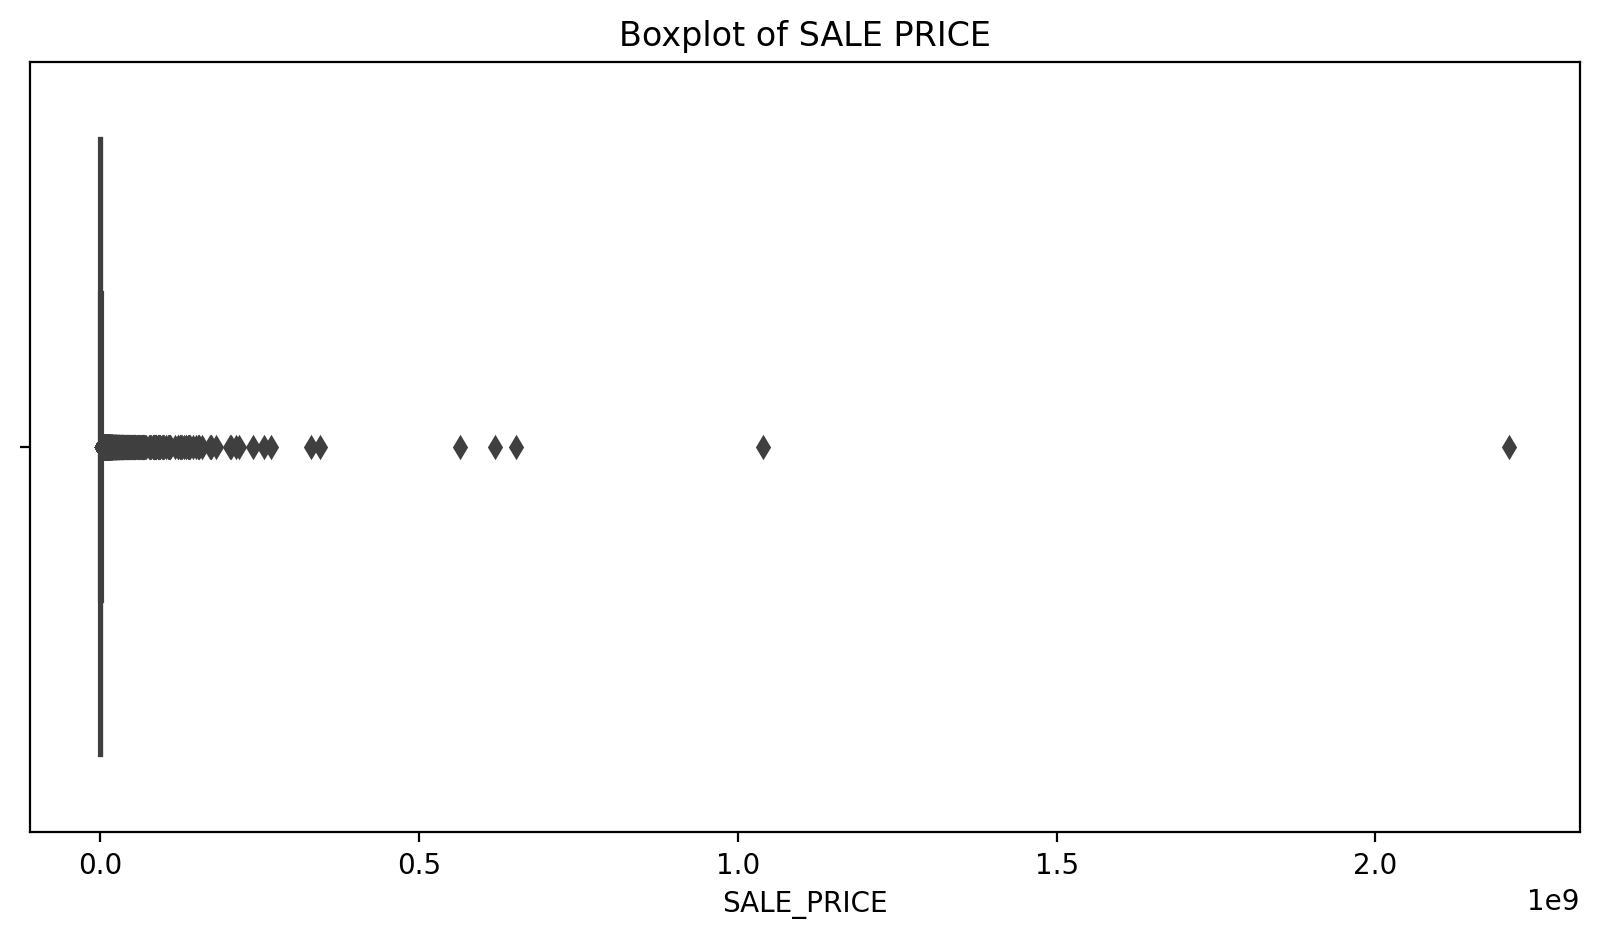

In [20]:
plt.figure(figsize=(10,5),dpi=200)

sns.boxplot(data=df,x="SALE_PRICE")
plt.xlabel("SALE_PRICE")
plt.title('Boxplot of SALE PRICE')
plt.show()

Detect and remove outliers with IQR (Interquartile Range) method


In [21]:
saleprice_q1 = df["SALE_PRICE"].describe().loc["25%"]
saleprice_q3 = df["SALE_PRICE"].describe().loc["75%"]
saleprice_iqr = saleprice_q3 - saleprice_q1

saleprice_lower_limit = saleprice_q1 - (1.5 * saleprice_iqr)
saleprice_upper_limit = saleprice_q3 + (1.5 * saleprice_iqr)

In [22]:
df_cleaned = df[(df["SALE_PRICE"] >= saleprice_lower_limit) & (df["SALE_PRICE"] <= saleprice_upper_limit)]
df_cleaned.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
12,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,1.0,2016-09-06
13,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,499000.0,2017-03-10
14,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,10.0,2017-04-28
15,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,529500.0,2017-06-09
16,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,423000.0,2017-07-14


c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


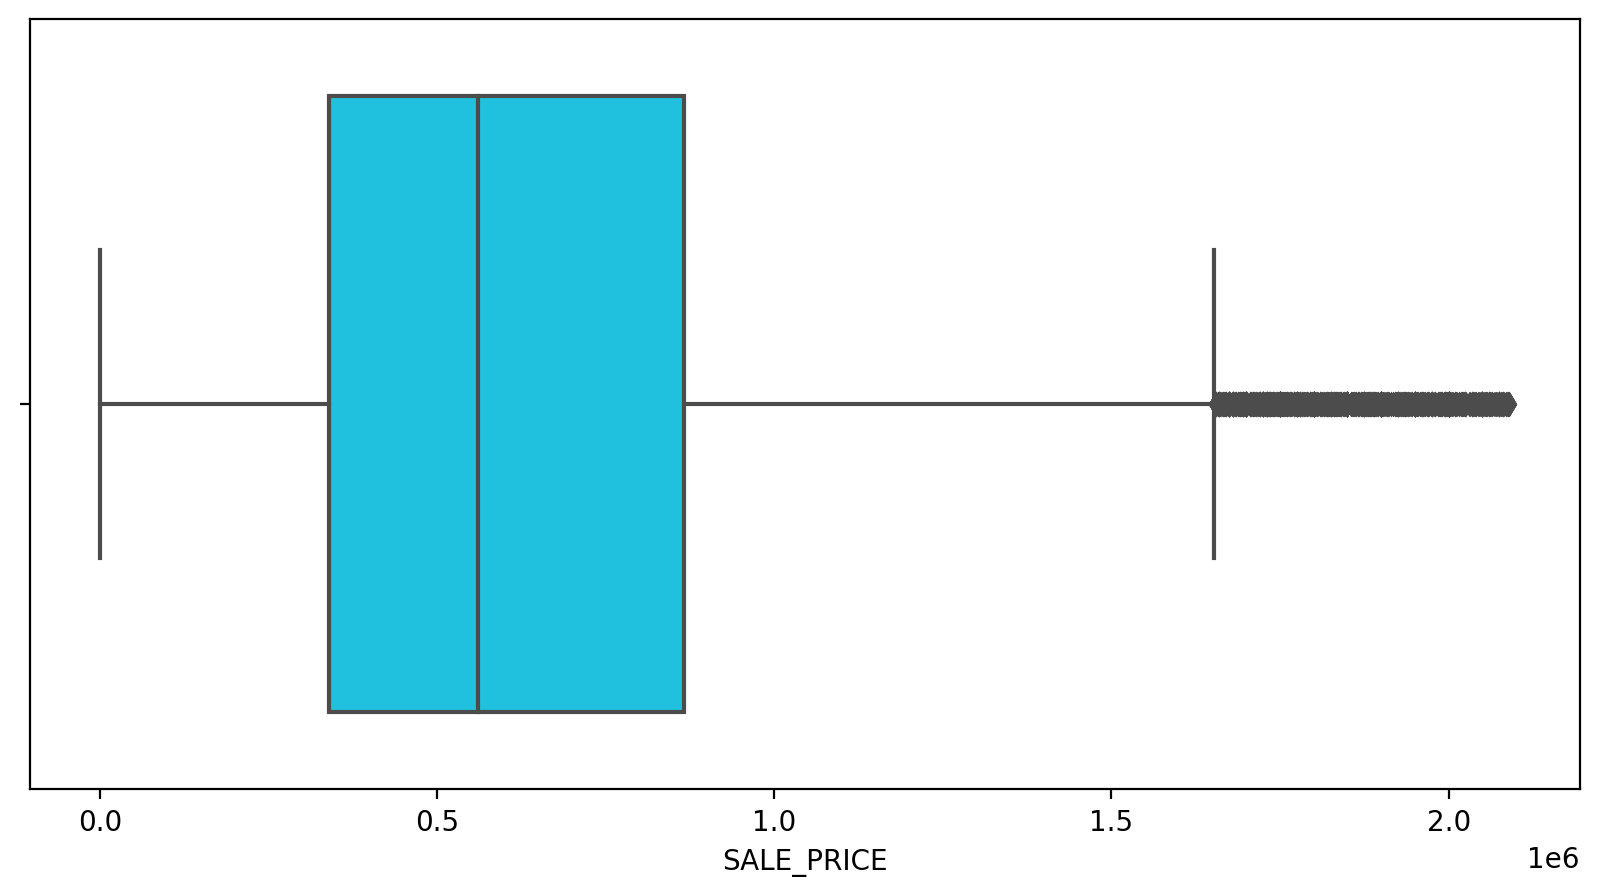

In [23]:
plt.figure(figsize=(10,5),dpi=200)

sns.boxplot(data=df_cleaned,x="SALE_PRICE",
            color=sns.color_palette("bright")[9])
plt.xlabel("SALE_PRICE")
plt.show()

The dataset still has many outliers, continue to repeat the step until the dataset no longer contains any outliers

In [24]:
n = 1
limit = 2

while n <= limit:
    saleprice_q1 = df_cleaned["SALE_PRICE"].describe().loc["25%"]
    saleprice_q3 = df_cleaned["SALE_PRICE"].describe().loc["75%"]
    saleprice_iqr = saleprice_q3 - saleprice_q1

    saleprice_lower_limit = saleprice_q1 - (1.5 * saleprice_iqr)
    saleprice_upper_limit = saleprice_q3 + (1.5 * saleprice_iqr)

    df_cleaned = df_cleaned[(df_cleaned["SALE_PRICE"] >= saleprice_lower_limit) 
                                        & (df_cleaned["SALE_PRICE"] <= saleprice_upper_limit)]
    
    n += 1

In [25]:
df_cleaned.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
12,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,1.0,2016-09-06
13,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,499000.0,2017-03-10
14,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,10.0,2017-04-28
15,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,529500.0,2017-06-09
16,Manhattan,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,C6,10009,0,0,0,0.0,0.0,1920,2,C6,423000.0,2017-07-14


c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


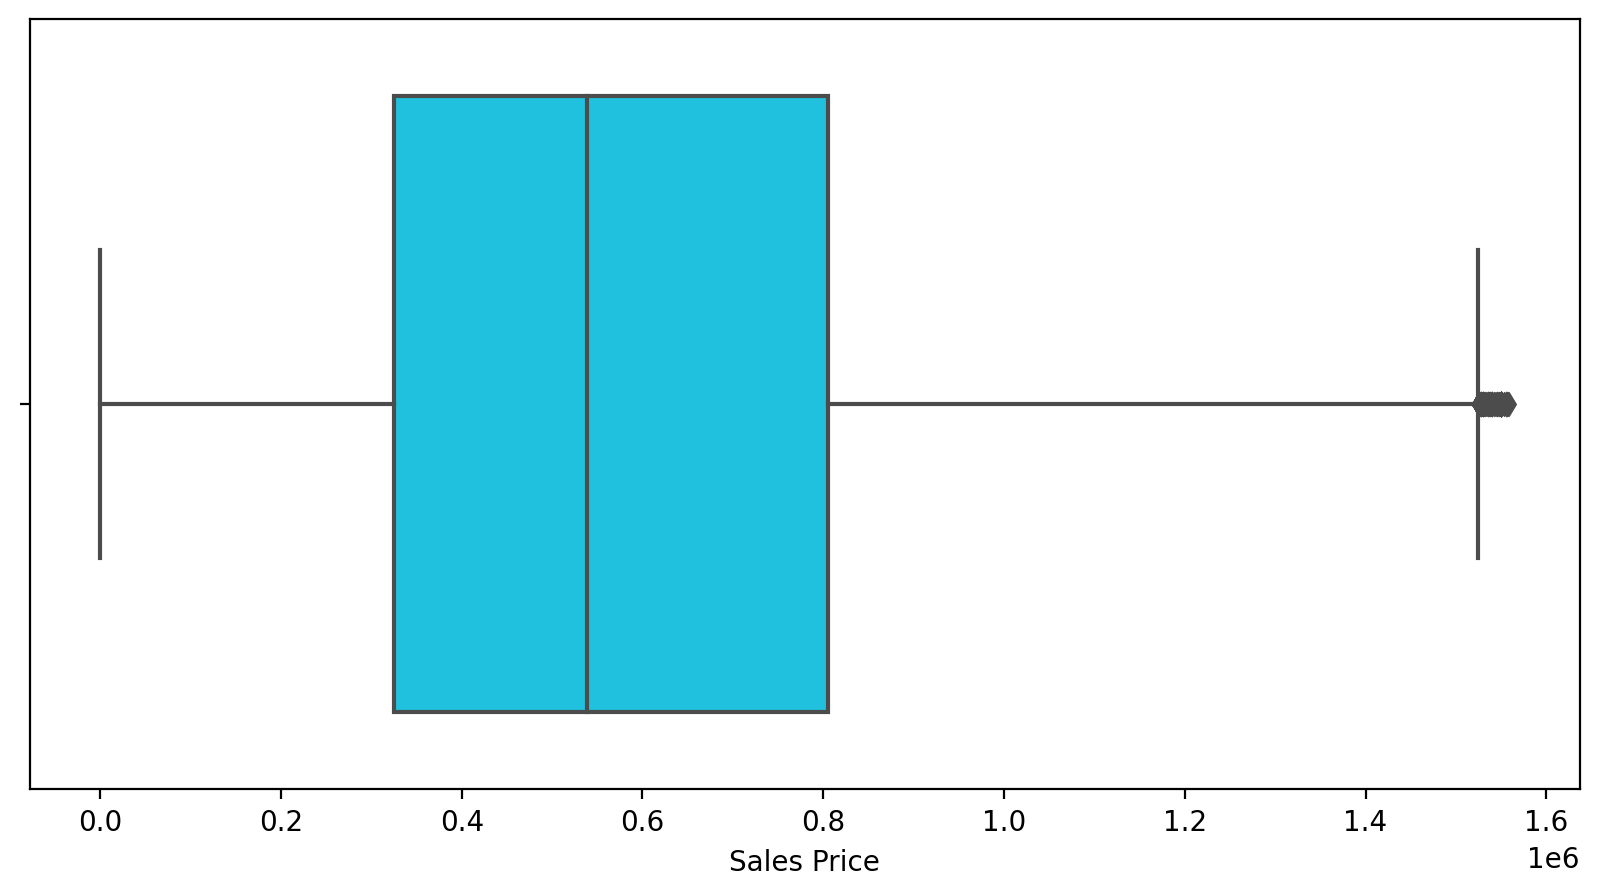

In [26]:
plt.figure(figsize=(10,5),dpi=200)

sns.boxplot(data=df_cleaned,x="SALE_PRICE",
            color=sns.color_palette("bright")[9])
plt.xlabel("Sales Price")
plt.show()

## Measures of Central Tendency

Compute statistical measures of central tendency by borough and tax_class_at_present, icluding:
- Mean
- Median
- Mode
- Range
- Variance
- Standard Deviation

In [27]:
measure_ct = df_cleaned.groupby(["BOROUGH","TAX_CLASS_AT_PRESENT"]).agg({"SALE_PRICE":[np.mean,
                                                                                    np.median,
                                                                                    statistics.mode,
                                                                                    np.ptp,
                                                                                    np.var,
                                                                             np.std]}).reset_index()
measure_ct.columns = measure_ct.columns.droplevel(-1)
measure_ct.columns = ["BOROUGH","TAX_CLASS_AT_PRESENT","MEAN","MEDIAN","MODE","RANGE","VARIANCE","STANDARD DEVIATION"]
measure_ct = measure_ct.dropna()
measure_ct

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9408\78055466.py:1: FutureWarning: The provided callable <function mean at 0x0000023AE7C62DE0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  measure_ct = df_cleaned.groupby(["BOROUGH","TAX_CLASS_AT_PRESENT"]).agg({"SALE_PRICE":[np.mean,
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9408\78055466.py:1: FutureWarning: The provided callable <function median at 0x0000023AE7D82C00> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'median' instead.
  measure_ct = df_cleaned.groupby(["BOROUGH","TAX_CLASS_AT_PRESENT"]).agg({"SALE_PRICE":[np.mean,
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9408\78055466.py:1: FutureWarning: The provided callable <function var at 0x0000023AE7C63060> is currently using SeriesGroupBy.var. In a future version

,BOROUGH,TAX_CLASS_AT_PRESENT,MEAN,MEDIAN,MODE,RANGE,VARIANCE,STANDARD DEVIATION
0,Bronx,1,4.504145e+05,450000.0,10.0,1549999.0,3.707326e+10,192544.183408
1,Bronx,1A,3.158523e+05,310000.0,230000.0,802281.0,2.226090e+10,149200.871084
2,Bronx,1B,3.361601e+05,290000.0,1000.0,1464999.0,1.180873e+11,343638.290800
3,Bronx,2,2.085942e+05,165000.0,110000.0,1549999.0,2.804608e+10,167469.651995
4,Bronx,2A,5.919874e+05,607500.0,650000.0,1529990.0,7.658155e+10,276733.717268
5,Bronx,2B,1.058427e+06,1100000.0,1100000.0,1554990.0,1.099603e+11,331602.622903
7,Bronx,4,5.732818e+05,550000.0,800000.0,1499999.0,1.788531e+11,422910.221549
8,Brooklyn,1,7.234036e+05,700000.0,10.0,1558999.0,1.432219e+11,378446.702578
9,Brooklyn,1A,5.522666e+05,529745.0,10.0,1509999.0,8.506974e+10,291667.179102
10,Brooklyn,1B,4.306487e+05,295100.5,150000.0,1449999.0,1.550468e+11,393759.777053


c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


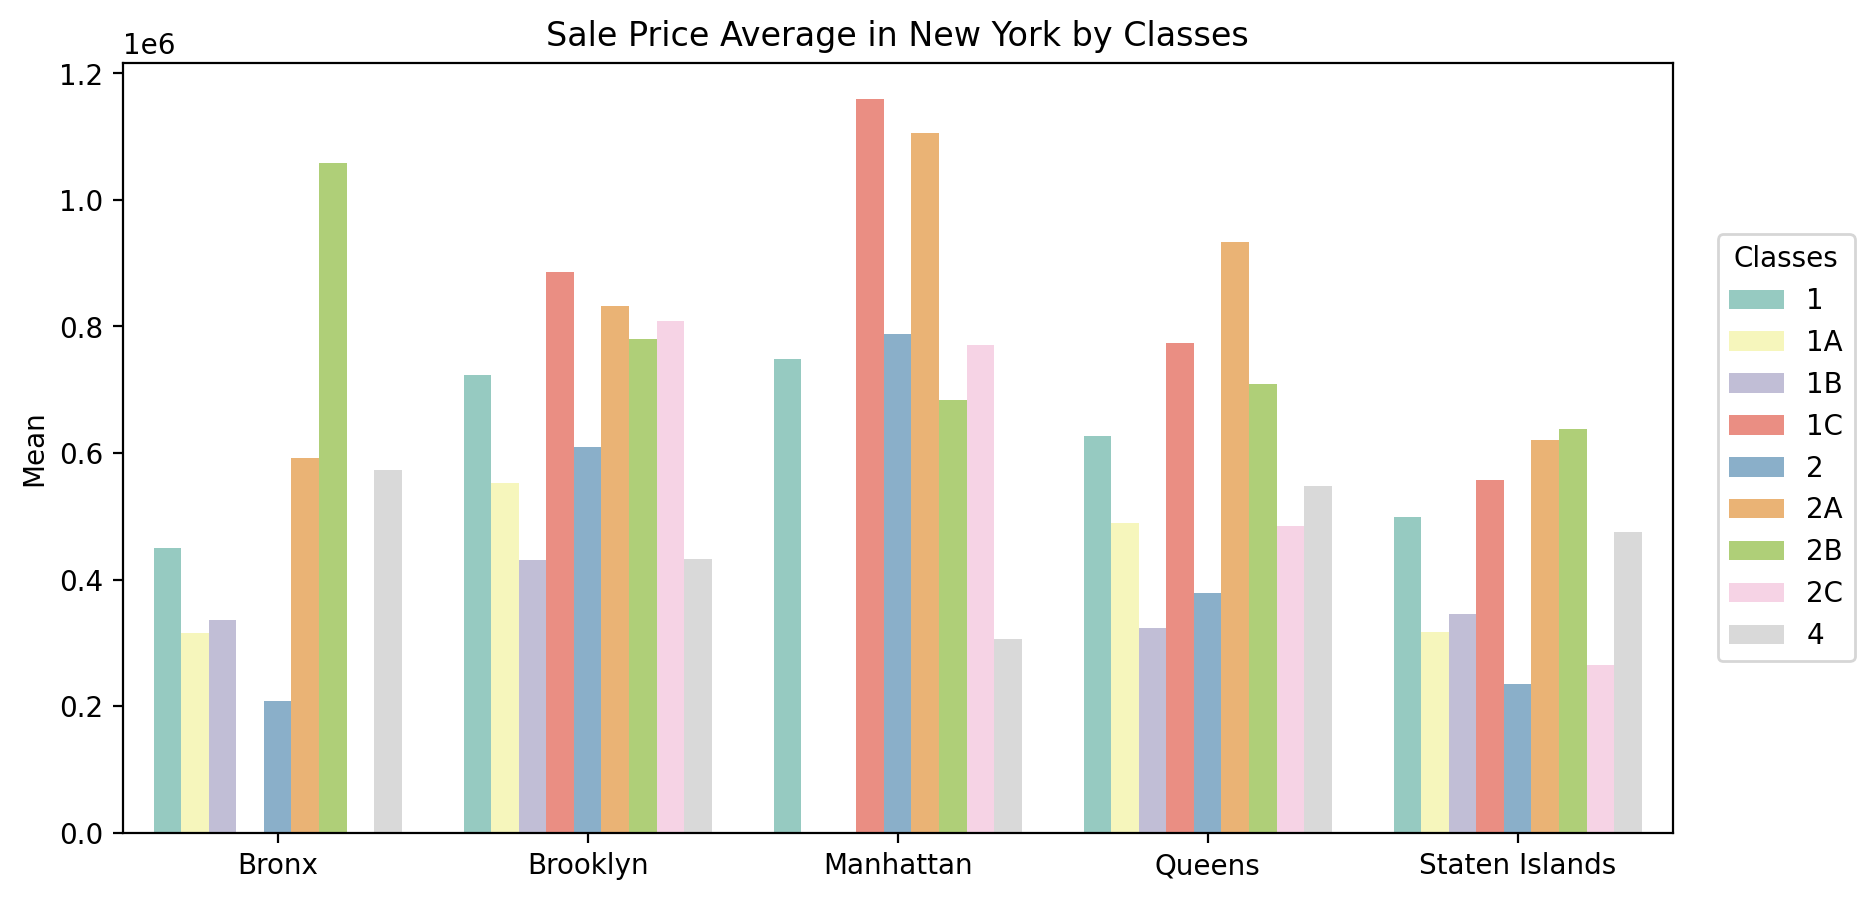

In [28]:
plt.figure(figsize=(10,5),dpi=200)
sns.barplot(data=measure_ct,x="BOROUGH",y="MEAN",hue="TAX_CLASS_AT_PRESENT",palette="Set3",
                hue_order=np.sort(measure_ct["TAX_CLASS_AT_PRESENT"].unique()))
plt.title("Sale Price Average in New York by Classes")
plt.xlabel("")
plt.ylabel("Mean")
plt.legend(bbox_to_anchor=(1.02,0.5),loc="center left",title="Classes")
plt.show()

## Confidence Intervals of the Sample Mean

Based on the measure_ct, it can be seen that Manhattan (1C), Manhattan (2A), dan Bronx (2B) is the top 3 in sale_price

In [29]:
top3_means = measure_ct.sort_values("MEAN", ascending=False).head(3)
top3_means

,BOROUGH,TAX_CLASS_AT_PRESENT,MEAN,MEDIAN,MODE,RANGE,VARIANCE,STANDARD DEVIATION
19,Manhattan,1C,1.159167e+06,1102500.0,900000.0,575000.0,8.506458e+10,291658.333214
21,Manhattan,2A,1.105614e+06,1300000.0,1320000.0,1524990.0,2.681566e+11,517838.423801
5,Bronx,2B,1.058427e+06,1100000.0,1100000.0,1554990.0,1.099603e+11,331602.622903


In [30]:
temp = []
for i,j in zip(top3_means["BOROUGH"],top3_means["TAX_CLASS_AT_PRESENT"]):
    temp.append(df_cleaned[(df_cleaned["BOROUGH"] == i) & 
                        (df_cleaned["TAX_CLASS_AT_PRESENT"] == j)])
    
top3_sale_price = np.array(pd.concat(temp)["SALE_PRICE"])
top3_sale_price

array([9.000000e+05, 1.102500e+06, 1.475000e+06, 1.000000e+01,
       3.130000e+05, 1.320000e+06, 1.800000e+05, 8.425000e+05,
       1.431326e+06, 1.100000e+06, 1.525000e+06, 1.300000e+06,
       1.300000e+06, 1.469500e+06, 1.275000e+06, 1.487500e+06,
       1.525000e+06, 1.400000e+06, 4.063000e+03, 1.320000e+06,
       1.500000e+06, 1.515000e+06, 1.130000e+06, 1.280000e+06,
       1.315000e+06, 8.800000e+05, 9.500000e+05, 1.100000e+06,
       1.175000e+06, 8.750000e+05, 1.200000e+06, 1.250000e+06,
       1.250000e+06, 1.100000e+06, 1.175000e+06, 1.525000e+06,
       1.100000e+06, 1.050000e+06, 4.300000e+04, 1.350000e+06,
       1.020000e+06, 1.400000e+06, 1.260000e+06, 7.500000e+05,
       1.555000e+06, 8.400000e+05, 1.000000e+06, 5.000000e+05,
       1.425000e+06, 1.200000e+06, 1.450000e+06, 1.232030e+06,
       1.150000e+06, 1.350000e+06, 1.265000e+06, 1.264000e+06,
       1.150000e+06, 1.100000e+06, 7.650000e+05, 1.380000e+06,
       1.000000e+06, 8.500000e+05, 9.400000e+05, 9.1000

Create the _sample_mean_, then take 30 random samples and calculate their means for 300 times

In [31]:
np.random.seed(9091)
sample_means = []
n = 30

for sample in range(300):
    sample_value = np.random.choice(a=top3_sale_price,size=n)
    sample_mean = np.mean(sample_value)
    sample_means.append(sample_mean)

Visualize the _sample_mean_

c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


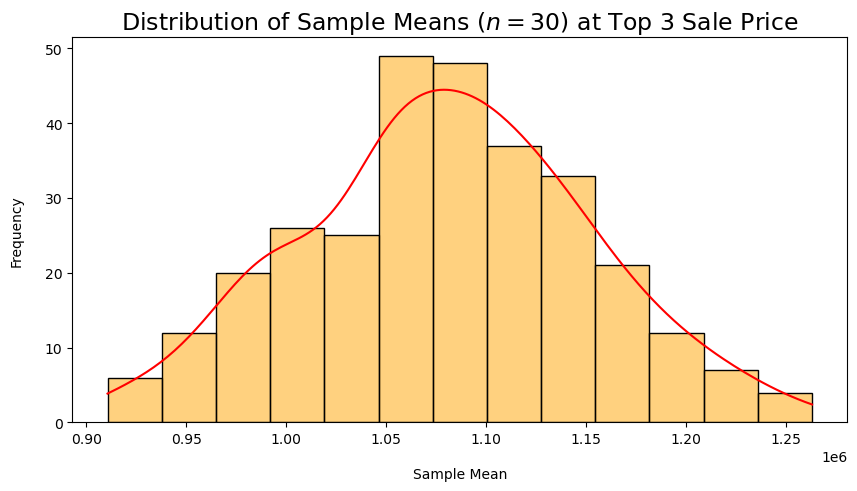

In [32]:
plt.figure(figsize=(10,5),dpi=100)
ax = sns.histplot(data=sample_means,kde=True,color="orange")
ax.lines[0].set_color("red")
plt.title("Distribution of Sample Means ($n=30$) at Top 3 Sale Price", fontsize=17)
plt.xlabel("Sample Mean", labelpad=15)
plt.ylabel("Frequency", labelpad=15);
plt.show()

Find the Z-Score

In [33]:
conf = 0.95
z = NormalDist().inv_cdf((1 + conf) / 2)
z 

1.9599639845400536

Calculate the median of sample_means, mean of sample_means, and std of sample_means

In [34]:
sample_of_mean_median = np.median(sample_means)
sample_of_mean_mean = np.mean(sample_means)
sample_of_mean_std = np.std(sample_means)

print("Median : ", sample_of_mean_median)
print("Mean : ", sample_of_mean_mean)
print("Std : ",sample_of_mean_std)

Median :  1082597.7666666666
Mean :  1079756.3685555556
Std :  71341.2058705018


Calculate the standard error of top3_sale_price

In [35]:
std_error = np.std(top3_sale_price) / np.sqrt(n)
std_error

71105.30441572449

Calculate the lower and upper limit

In [36]:
lower_95 = sample_of_mean_mean - (z * std_error)
upper_95 = sample_of_mean_mean + (z * std_error)

print("Lower Limit : ", lower_95)
print("Upper Limit : ", upper_95)

Lower Limit :  940392.5327909788
Upper Limit :  1219120.2043201325


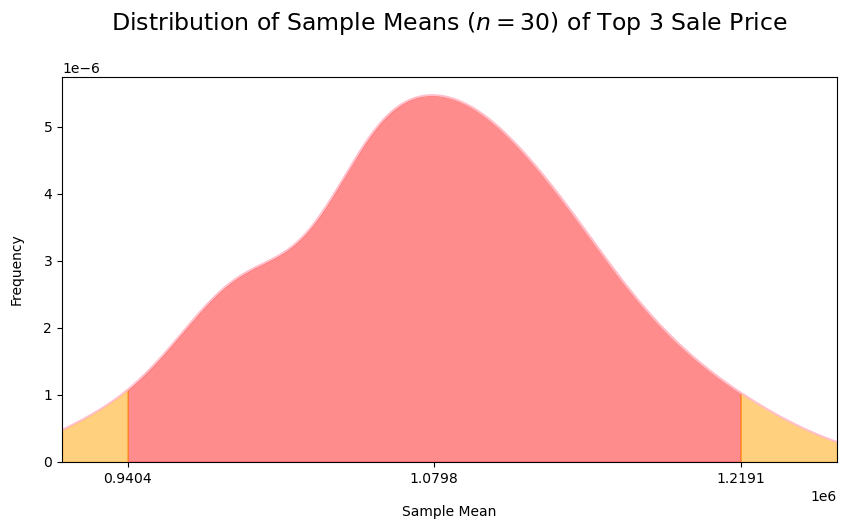

In [37]:
plt.figure(figsize=(10,5),dpi=100)
kde = gaussian_kde(sample_means)
pos = np.linspace(np.min(sample_means), np.max(sample_means), 10000)
plt.plot(pos, kde(pos), color="pink")
shade = np.linspace(lower_95, upper_95, 300)

plt.fill_between(shade, kde(shade), alpha=0.45, color='red')
plt.xticks([lower_95,sample_of_mean_mean,upper_95])
plt.xlim(xmin=np.min(sample_means),xmax=np.max(sample_means))
plt.ylim(ymin=0)

left = np.linspace(np.min(sample_means),lower_95,10000)
right = np.linspace(upper_95,np.max(sample_means),10000)
for i in [left,right]:
    plt.fill_between(i,kde(i),color="orange",alpha=0.5)
    
# plt.text(x=154, y=0.01, horizontalalignment='center', fontsize=3, s="95% of sample means fall within\nthis shaded area of plus or minus\n1.96 z-scores from the mean", bbox=dict(facecolor='whitesmoke', boxstyle="round, pad=0.1"))
plt.title("Distribution of Sample Means ($n=30$) of Top 3 Sale Price", y=1.1, fontsize=17)
plt.xlabel("Sample Mean", labelpad=14)
plt.ylabel("Frequency", labelpad=14);
plt.show()

Conclusion: Based on the plot, the determined is $95%$% chance that the mean of a sample $N=30$ will be within the pink shaded area. Thus, the probability that the mean of a sample with $N=30$ will be outside the pink shaded area 5%

## Probability Distribution & Hypothesis Testing ##

### Hypothesis ###

- _H0_ : top3_sale_price data is normally 
- _H1_ : top3_sale_price data is not normally distributed

### Significance Level

alfa = 5%

### Test Statistics

c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


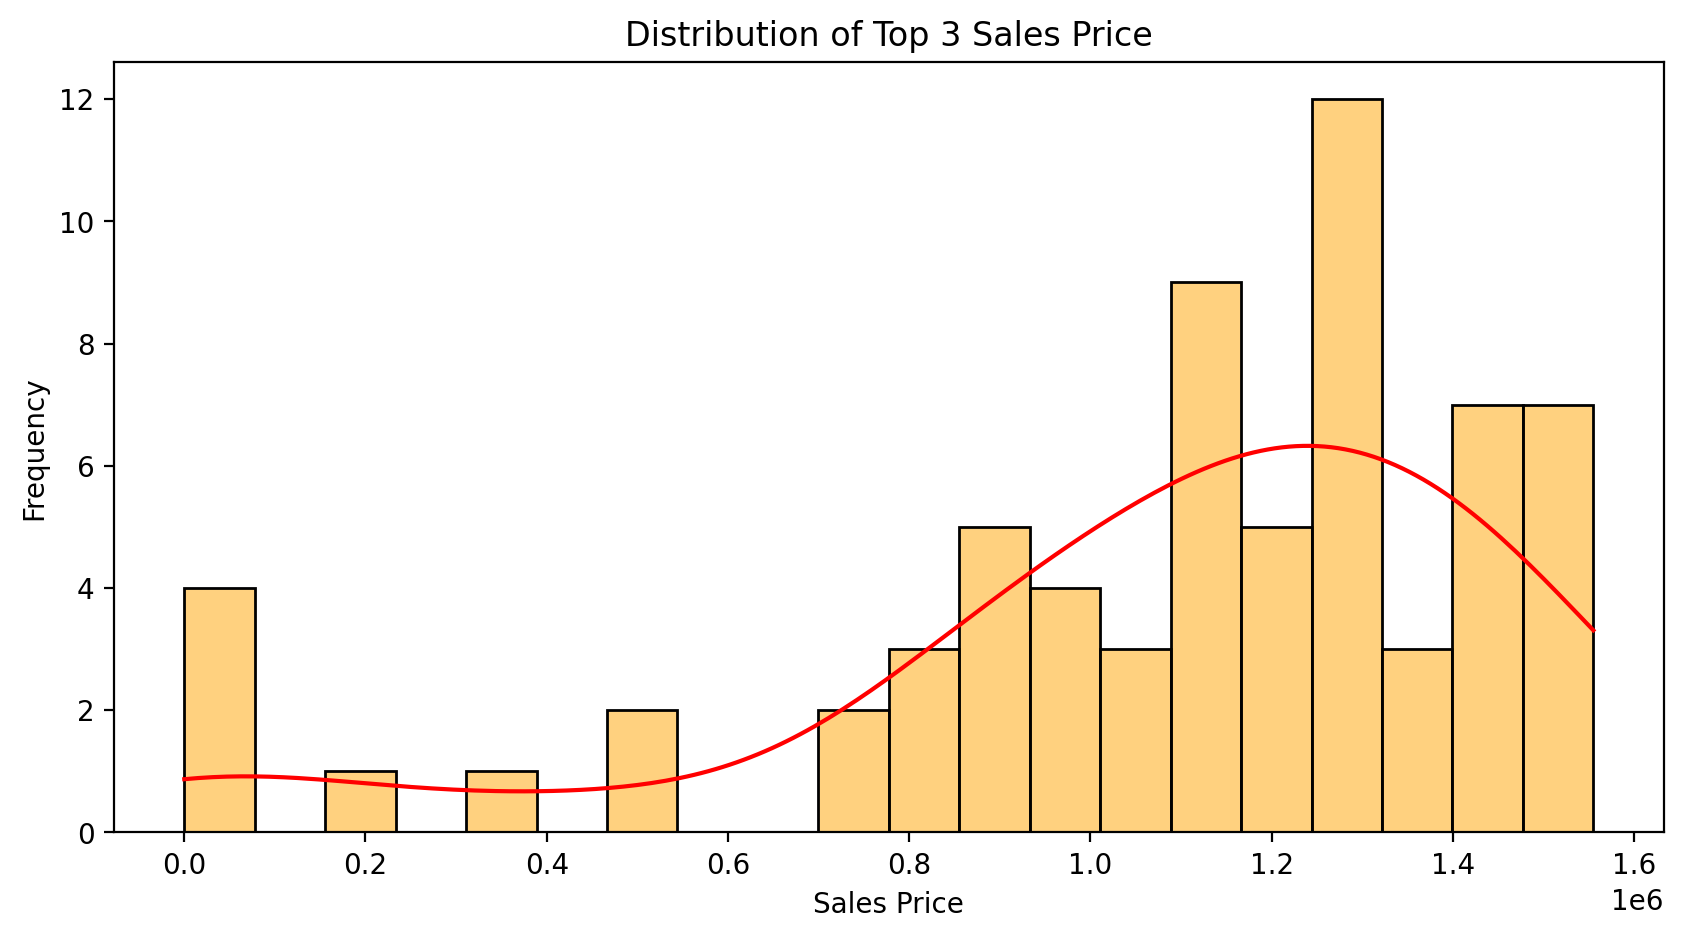

,Kolmogorov-Smirnov,Prob. (K-S),Shapiro-Wilk,Prob. (S-W)
,0.155275,0.000325,0.858422,0.000002


In [38]:
plt.figure(figsize=(10,5),dpi=200)
ax = sns.histplot(data=top3_sale_price,bins=20,kde=True,color="orange")
ax.lines[0].set_color("red")
plt.title("Distribution of Top 3 Sales Price")
plt.xlabel("Sales Price")
plt.ylabel("Frequency")
plt.show()

ks_stat,ks_pvalue = lilliefors(top3_sale_price,dist="norm",pvalmethod="approx")
sw_stat,sw_pvalue = shapiro(top3_sale_price)

pd.DataFrame({
    "Kolmogorov-Smirnov":[ks_stat],
    "Prob. (K-S)":[ks_pvalue],
    "Shapiro-Wilk":[sw_stat],
    "Prob. (S-W)":[sw_pvalue]
},index=[""])

**Conclusion**: To formally assess normality, one can employ the Kolmogorov-Smirnov test with Lilliefors significance correction and the Shapiro-Wilk test. From the above output, it is observed that the probability value for K-S is 0,000325 and the probability value for S-W is 0,000002 both of which are less than 0,05. Consequently, it can be inferred that top3_sale_price doesn't a normal distribution.

### Transformation

Since the data is not normal, it can be transformed to become normally distributed. Based on the output above, the distribution has a moderate negative skewness, so for the transformation, we can use the formula $$\sqrt(k-x)$$

In [39]:
transform_top3 = np.sqrt(np.max(top3_sale_price) - top3_sale_price)
transform_top3

array([ 809.32070281,  672.68120235,  282.84271247, 1246.99238169,
       1114.45053726,  484.76798574, 1172.60393996,  844.09715081,
        351.6731437 ,  674.53687816,  173.20508076,  504.97524692,
        504.97524692,  292.40383034,  529.15026221,  259.80762114,
        173.20508076,  393.7003937 , 1245.3662112 ,  484.76798574,
        234.52078799,  200.        ,  651.92024052,  524.40442409,
        489.89794856,  821.58383626,  777.81745931,  674.53687816,
        616.4414003 ,  824.62112512,  595.81876439,  552.26805086,
        552.26805086,  674.53687816,  616.4414003 ,  173.20508076,
        674.53687816,  710.63352018, 1229.63409192,  452.76925691,
        731.43694192,  393.7003937 ,  543.13902456,  897.21792225,
          0.        ,  845.57672626,  744.98322129, 1027.13192921,
        360.55512755,  595.81876439,  324.03703492,  568.30449585,
        636.39610307,  452.76925691,  538.51648071,  539.44415837,
        636.39610307,  674.53687816,  888.81944173,  418.33001

c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Lenovo\Latihan pertemuan 1\env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


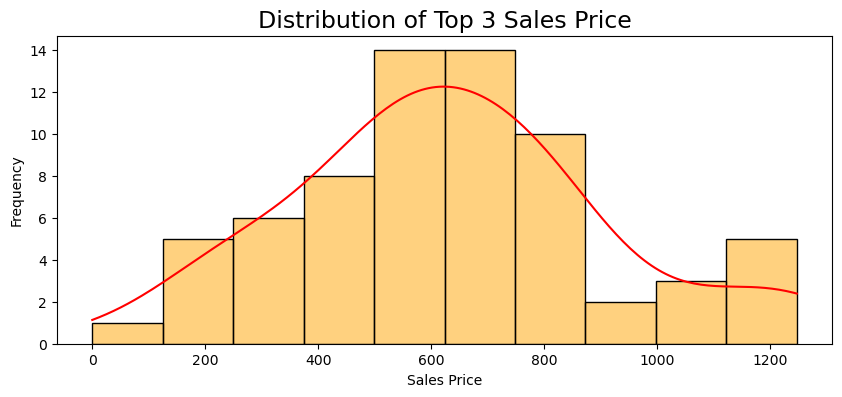

,Kolmogorov-Smirnov,Prob. (K-S),Shapiro-Wilk,Prob. (S-W)
,0.076455,0.479724,0.975025,0.188753


In [40]:
plt.figure(figsize=(10,4), dpi=100)
ax = sns.histplot(data=transform_top3,bins=10,kde=True, color="orange")
ax.lines[0].set_color("red")
plt.xlabel("Sales Price")
plt.ylabel("Frequency")
plt.title("Distribution of Top 3 Sales Price", fontsize=17)
plt.show()

ks_stat,ks_pval = lilliefors(transform_top3,dist="norm",pvalmethod="approx")
sw_stat,sw_pval = shapiro(transform_top3)

pd.DataFrame({
    "Kolmogorov-Smirnov":[ks_stat],
    "Prob. (K-S)":[ks_pval],
    "Shapiro-Wilk":[sw_stat],
    "Prob. (S-W)":[sw_pval]
},index=[""])

### Conclusion ###

**Conclusion** : At the 5% significance level, $H0$ was rejected because both p-values from the Kolmogorov-Smirnov test and the Shapiro-Wilk test were less than 0.05. However, after the data was transformed, $H0$ is now accepted because the probability of Kolmogorov-Smirnov is 0,479724 and the probability of Shapiro-Wilk is 0,188753 are greater than 0,05.Based on the output above, the visually of distribution is approximately symmetric. Therefore, it can be concluded that the data of top3_sale_price is normally distribution.